# **Lab 3**
# 1, Obtain and download the data
The data is downloaded from Kaggle. The dataset contains images of dogs and cats. The data will be divided into training, validation, and test sets. There are totally 5000 images. Each image has a resolution of 180×180.
Sources come from: (https://www.kaggle.com/datasets/biaiscience/dogs-vs-cats, with Open Data license)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_file_path = "/content/drive/MyDrive/train.zip"

if zipfile.is_zipfile(zip_file_path):
    print("valid")
else:
    print("not valid")


valid


In [3]:
import zipfile
import os


zip_file_path = "/content/drive/MyDrive/train.zip"
extract_to_path = "/content/train"


if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_path)
        print(f"zip in {extract_to_path}")
else:
    print(f"zip {zip_file_path} dont exist")


zip in /content/train


In [4]:
import os, shutil, pathlib

original_dir = pathlib.Path("/content/train/train")
new_base_dir = pathlib.Path("/content/kaggle_dogs_vs_cats")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=4000)
make_subset("validation", start_index=4000, end_index=4750)
make_subset("test", start_index=4750, end_index=5000)

# 2. EDA


# Basic information and distribution

Summary:
       subset category  file_count
0       train      cat        4000
1       train      dog        4000
2  validation      cat         750
3  validation      dog         750
4        test      cat         250
5        test      dog         250


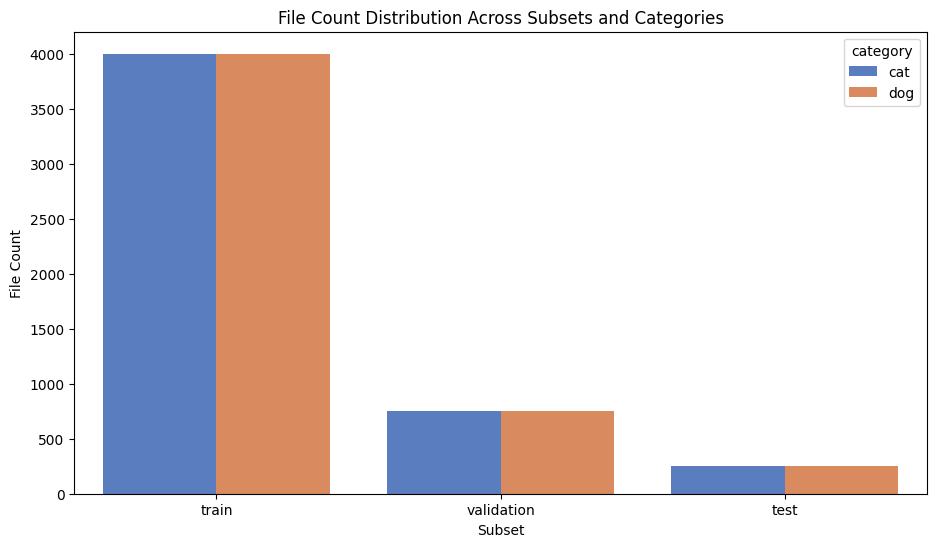

In [5]:
import os
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

new_base_dir = Path("/content/kaggle_dogs_vs_cats")
subsets = ["train", "validation", "test"]
categories = ["cat", "dog"]

data = {"subset": [], "category": [], "file_count": []}

for subset in subsets:
    for category in categories:
        dir_path = new_base_dir / subset / category
        if dir_path.exists():
            file_count = len(os.listdir(dir_path))
        else:
            file_count = 0
        data["subset"].append(subset)
        data["category"].append(category)
        data["file_count"].append(file_count)

df = pd.DataFrame(data)
print("Summary:")
print(df)

plt.figure(figsize=(11, 6))
sns.barplot(x="subset", y="file_count", hue="category", data=df, palette="muted")
plt.title("File Count Distribution Across Subsets and Categories")
plt.ylabel("File Count")
plt.xlabel("Subset")
plt.show()


# Display sample images

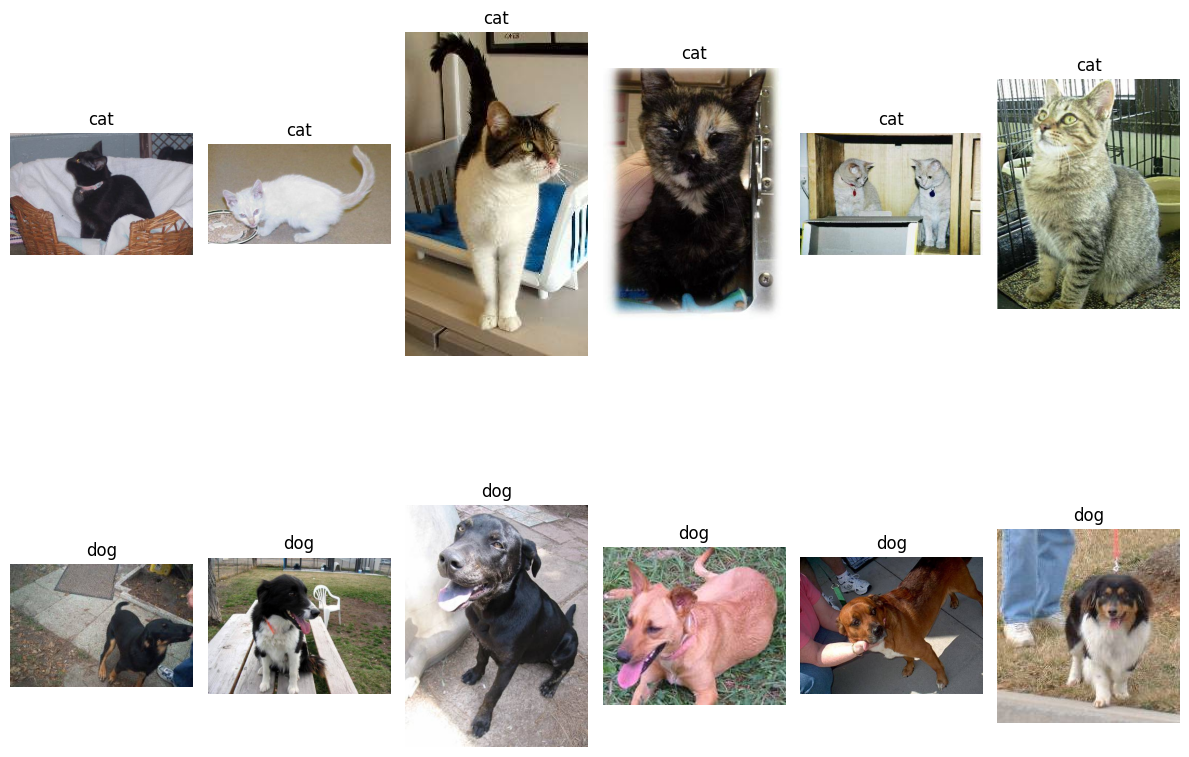

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from pathlib import Path

def display_sample_images(base_dir, subset, categories, num_images=12):
    plt.figure(figsize=(12, 10))
    images_per_category = num_images // len(categories)

    img_index = 1
    for category in categories:
        category_dir = base_dir / subset / category
        all_images = list(category_dir.glob("*.jpg"))
        selected_images = random.sample(all_images, images_per_category)

        for img_path in selected_images:
            ax = plt.subplot(len(categories), images_per_category, img_index)
            img = mpimg.imread(img_path)
            plt.imshow(img)
            plt.title(f"{category}")
            plt.axis("off")
            img_index += 1

    plt.tight_layout()
    plt.show()

# 使用函数显示训练集的样本图片
display_sample_images(
    base_dir=new_base_dir,
    subset="train",
    categories=categories,
    num_images=12
)


# 3. Train two networks


# SqueezeNet

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib


data_folder = pathlib.Path("/content/kaggle_dogs_vs_cats")


squeezenet_train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(224, 224),  # SqueezeNet  224x224
    batch_size=32
)

squeezenet_validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(224, 224),
    batch_size=32
)

squeezenet_test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(224, 224),
    batch_size=32
)


def squeezenet_preprocess(images, labels):
    images = images / 255.0  #
    return images, labels

squeezenet_train_dataset = squeezenet_train_dataset.map(squeezenet_preprocess)
squeezenet_validation_dataset = squeezenet_validation_dataset.map(squeezenet_preprocess)
squeezenet_test_dataset = squeezenet_test_dataset.map(squeezenet_preprocess)


def squeezenet_fire_module(x, squeeze_channels, expand_channels):
    squeeze = layers.Conv2D(squeeze_channels, (1, 1), activation='relu')(x)
    expand1x1 = layers.Conv2D(expand_channels, (1, 1), activation='relu')(squeeze)
    expand3x3 = layers.Conv2D(expand_channels, (3, 3), padding='same', activation='relu')(squeeze)
    return layers.Concatenate()([expand1x1, expand3x3])


def build_squeezenet(input_shape=(224, 224, 3)):
    inputs = keras.Input(shape=input_shape)

    # Initial Convolution
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), activation='relu')(inputs)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Fire Modules
    x = squeezenet_fire_module(x, squeeze_channels=16, expand_channels=64)
    x = squeezenet_fire_module(x, squeeze_channels=16, expand_channels=64)
    x = squeezenet_fire_module(x, squeeze_channels=32, expand_channels=128)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = squeezenet_fire_module(x, squeeze_channels=32, expand_channels=128)
    x = squeezenet_fire_module(x, squeeze_channels=48, expand_channels=192)
    x = squeezenet_fire_module(x, squeeze_channels=48, expand_channels=192)
    x = squeezenet_fire_module(x, squeeze_channels=64, expand_channels=256)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    # Final Convolution
    x = layers.Conv2D(1, (1, 1), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Activation('sigmoid')(x)

    return keras.Model(inputs, outputs)


squeezenet_model = build_squeezenet()
squeezenet_model.summary()


squeezenet_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=["accuracy"]
)

# recall function
squeezenet_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/squeezenet.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


squeezenet_history = squeezenet_model.fit(
    squeezenet_train_dataset,
    epochs=5,
    validation_data=squeezenet_validation_dataset,
    callbacks=squeezenet_callbacks
)


squeezenet_test_loss, squeezenet_test_accuracy = squeezenet_model.evaluate(squeezenet_test_dataset)
print(f"SqueezeNet Test Accuracy: {squeezenet_test_accuracy:.2f}")


Found 8000 files belonging to 2 classes.
Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 109, 109, 96)   │         14,208 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 96)     │              0 │ conv2d_23[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 54, 54, 16)     │          1,552 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_24[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 54, 54, 128)    │              0 │ conv2d_25[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_26[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 54, 54, 16)     │          2,064 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 54, 54, 128)    │              0 │ conv2d_28[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 54, 54, 32)     │          4,128 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 54, 54, 128)    │          4,224 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 54, 54, 128)    │         36,992 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 54, 54, 256)    │              0 │ conv2d_31[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 26, 26, 256)    │              0 │ concatenate_9[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)   

 Total params: 538,753 (2.06 MB)

 Trainable params: 538,753 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1337s 5s/step - accuracy: 0.4891 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1315s 5s/step - accuracy: 0.4876 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1338s 5s/step - accuracy: 0.4896 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1333s 5s/step - accuracy: 0.4873 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 1298s 5s/step - accuracy: 0.4879 - loss: 0.6931 - val_accuracy: 0.5000 - val_loss: 0.6931
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - accuracy: 0.5247 - loss: 0.6931
SqueezeNet Test Accuracy: 0.50


Training and Validation Accuracy & Loss

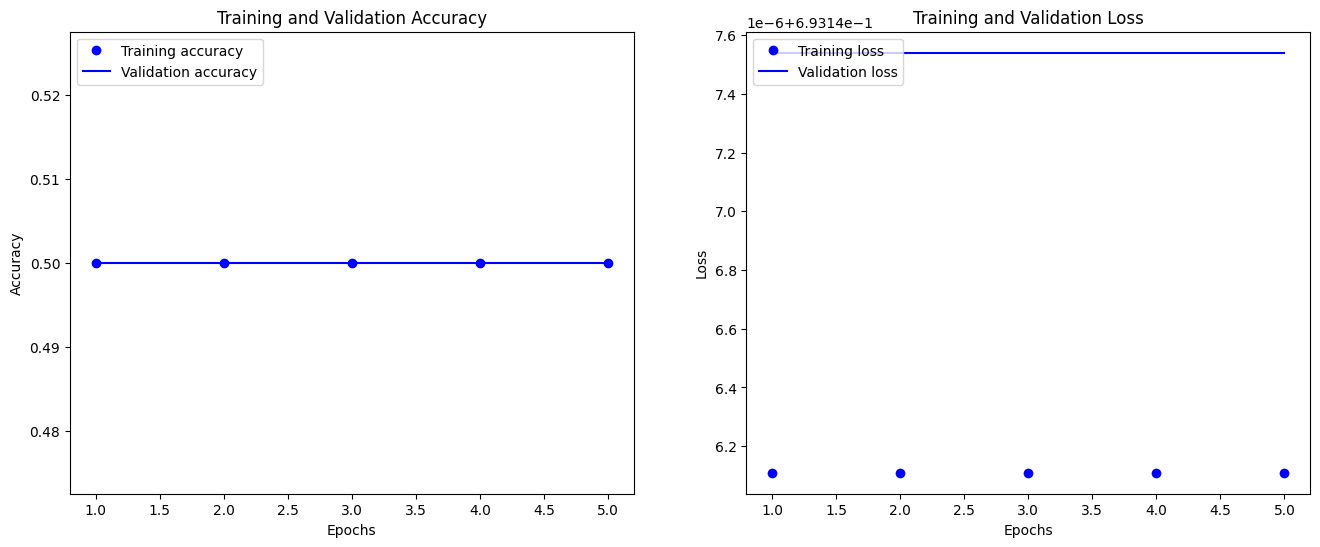

In [17]:
import matplotlib.pyplot as plt

def plot_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(accuracy) + 1)


    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs_range, val_accuracy, "b", label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend(loc="upper left")

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, "bo", label="Training loss")
    plt.plot(epochs_range, val_loss, "b", label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend(loc="upper left")

    plt.show()


plot_history(squeezenet_history)


# Vgg 16

In [7]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory


data_folder = pathlib.Path("/content/kaggle_dogs_vs_cats")

train_dataset = image_dataset_from_directory(
    data_folder / "train",
    image_size=(180, 180),
    batch_size=32
)

validation_dataset = image_dataset_from_directory(
    data_folder / "validation",
    image_size=(180, 180),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    data_folder / "test",
    image_size=(180, 180),
    batch_size=32
)


conv_base = keras.applications.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3)
)
conv_base.summary()


def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:

        preprocessed_images = keras.applications.vgg16.preprocess_input(images)

        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)


train_features, train_labels = get_features_and_labels(train_dataset)
val_features, val_labels = get_features_and_labels(validation_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)


print("Train features shape:", train_features.shape)


inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.summary()


model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"]
)


callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="./models/vgg16_fine_tuned.keras",
        save_best_only=True,
        monitor="val_loss"
    )
]


history = model.fit(
    train_features,
    train_labels,
    epochs=30,
    validation_data=(val_features, val_labels),
    callbacks=callbacks
)

test_loss, test_accuracy = model.evaluate(test_features, test_labels)
print(f"Test Accuracy: {test_accuracy:.2f}")


Found 8000 files belonging to 2 classes.
Found 1500 files belonging to 2 classes.
Found 500 files belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,277,313 (12.50 MB)

 Trainable params: 3,277,313 (12.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.9162 - loss: 4.0252 - val_accuracy: 0.9693 - val_loss: 0.5029
Epoch 2/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9757 - loss: 0.2367 - val_accuracy: 0.9780 - val_loss: 0.2647
Epoch 3/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9826 - loss: 0.1578 - val_accuracy: 0.9767 - val_loss: 0.3452
Epoch 4/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.9929 - loss: 0.0579 - val_accuracy: 0.9807 - val_loss: 0.3436
Epoch 5/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.9914 - loss: 0.0670 - val_accuracy: 0.9793 - val_loss: 0.3576
Epoch 6/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.9918 - loss: 0.0671 - val_accuracy: 0.9773 - val_loss: 0.4130
Epoch 7/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.9934 - loss: 0.0470 - val_accuracy: 0.9780 - val_loss: 0.3775
Epoch 8/30
250/250 ━━━━━━━━━━━━━━━━━━━━ 19s 46ms/step - accuracy: 0.9950 - loss: 0.0390 - 

Training and Validation Accuracy & Loss

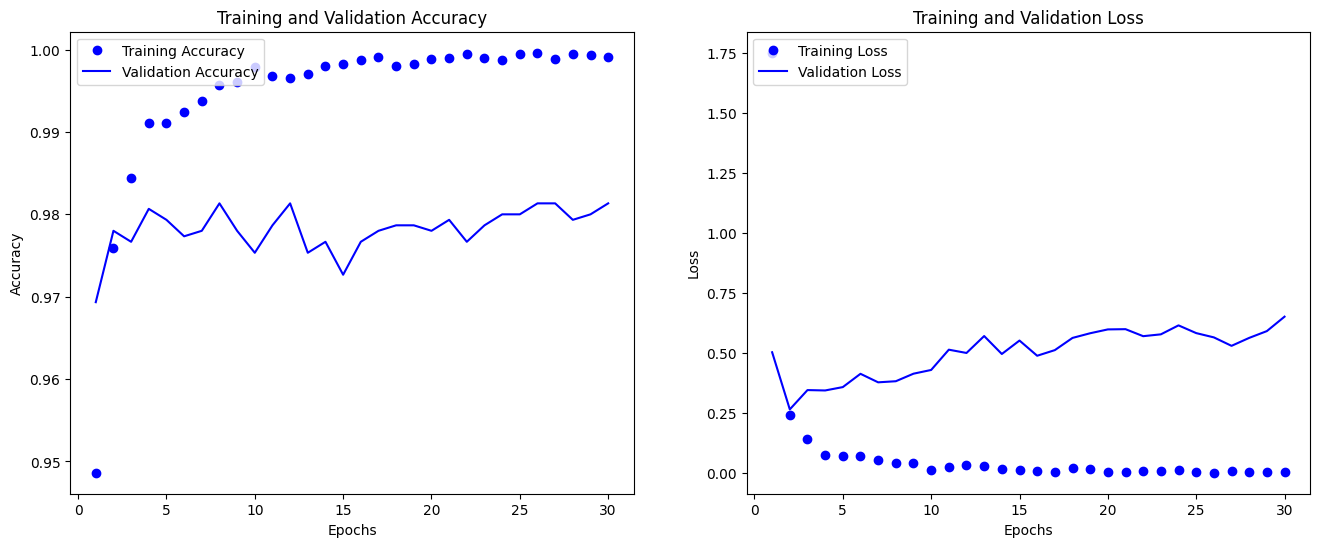

In [18]:
import matplotlib.pyplot as plt


def plot_vgg16_history(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs_range = range(1, len(accuracy) + 1)


    plt.figure(figsize=(16, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, "bo", label="Training Accuracy")
    plt.plot(epochs_range, val_accuracy, "b", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.legend(loc="upper left")


    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, "bo", label="Training Loss")
    plt.plot(epochs_range, val_loss, "b", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend(loc="upper left")

    plt.show()


plot_vgg16_history(history)


# 4. Explore the relative performance of the models

# Squeezenet:

Evaluating SqueezeNet...
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 687ms/step
SqueezeNet Accuracy: 0.50
Confusion Matrix (SqueezeNet):
 [[250   0]
 [250   0]]
Classification Report (SqueezeNet):
               precision    recall  f1-score   support

         Cat       0.50      1.00      0.67       250
         Dog       0.00      0.00      0.00       250

    accuracy                           0.50       500
   macro avg       0.25      0.50      0.33       500
weight

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


16/16 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step


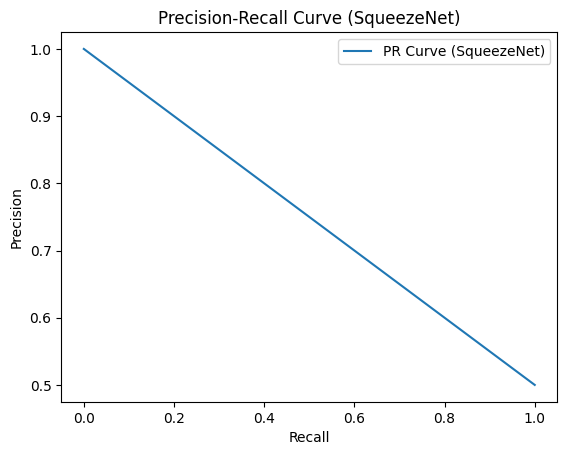

Analyzing Failures for SqueezeNet...


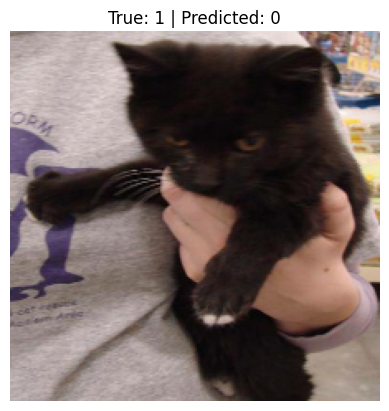

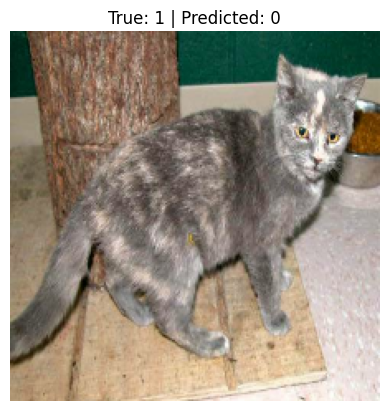

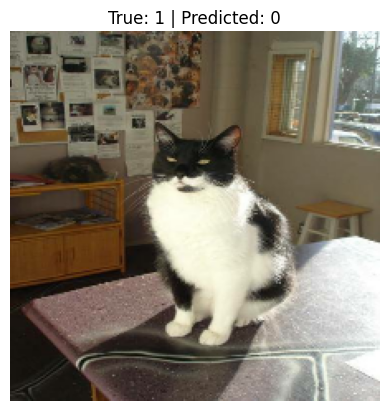

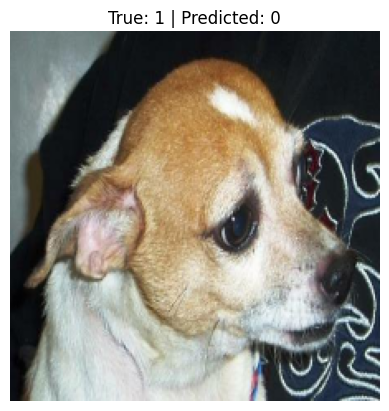

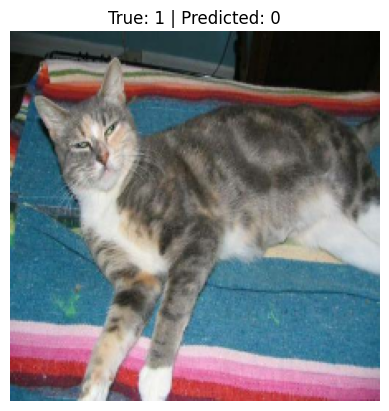

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve


def evaluate_squeezenet(model, dataset, dataset_name):
    y_true = []
    y_pred = []


    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend((predictions > 0.5).astype(int).flatten())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)


    accuracy = np.mean(y_true == y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix ({dataset_name}):\n", cm)
    report = classification_report(y_true, y_pred, target_names=["Cat", "Dog"])
    print(f"Classification Report ({dataset_name}):\n", report)
    y_proba = model.predict(dataset.map(lambda x, y: x))
    precision, recall, _ = precision_recall_curve(y_true, y_proba.flatten())
    plt.figure()
    plt.plot(recall, precision, label=f"PR Curve ({dataset_name})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({dataset_name})")
    plt.legend()
    plt.show()

    wrong_predictions = np.where(y_true != y_pred)[0]
    return y_true, y_pred, wrong_predictions


def analyze_failures_squeezenet(dataset, y_true, y_pred, wrong_indices):
    print(f"Analyzing Failures for SqueezeNet...")
    for idx in wrong_indices[:5]:
        for batch_idx, (images, labels) in enumerate(dataset):
            if idx < len(labels):

                image = images[idx].numpy()
                if image.max() <= 1.0:
                    image = (image * 255).astype("uint8")

                plt.figure()
                if image.shape[-1] == 3:
                    plt.imshow(image)
                else:
                    plt.imshow(image.squeeze(), cmap='gray')
                plt.title(f"True: {y_true[idx]} | Predicted: {y_pred[idx]}")
                plt.axis('off')
                plt.show()
                break
            idx -= len(labels)

print("Evaluating SqueezeNet...")
y_true_sn, y_pred_sn, wrong_sn = evaluate_squeezenet(squeezenet_model, squeezenet_test_dataset, "SqueezeNet")

analyze_failures_squeezenet(squeezenet_test_dataset, y_true_sn, y_pred_sn, wrong_sn)


Evaluating VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
VGG16 Accuracy: 0.98
Confusion Matrix (VGG16):
 [[247   3]
 [  6 244]]
Classification Report (VGG16):
               precision    recall  f1-score   support

         Cat       0.98      0.99      0.98       250
         Dog       0.99      0.98      0.98       250

    accuracy                           0.98       500
   macro avg  

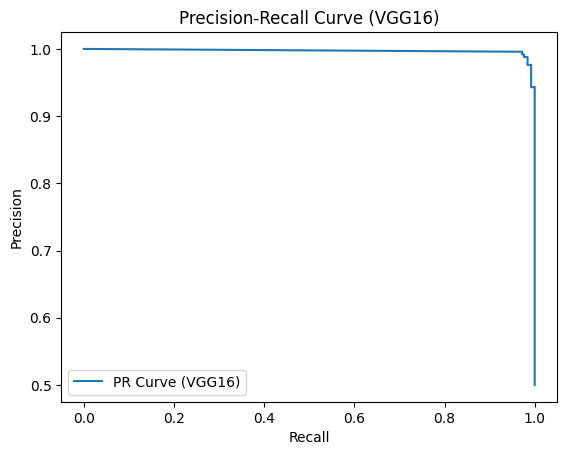

Analyzing Failures for VGG16...
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


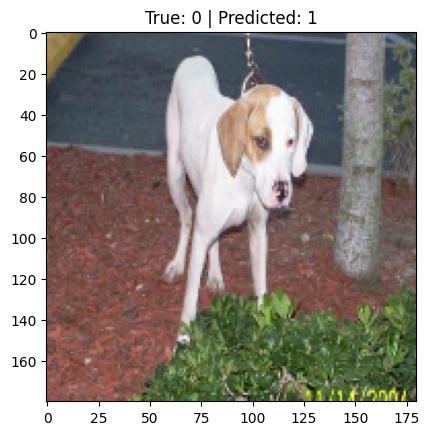

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


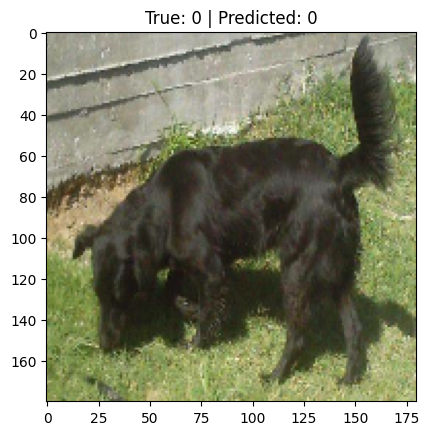

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


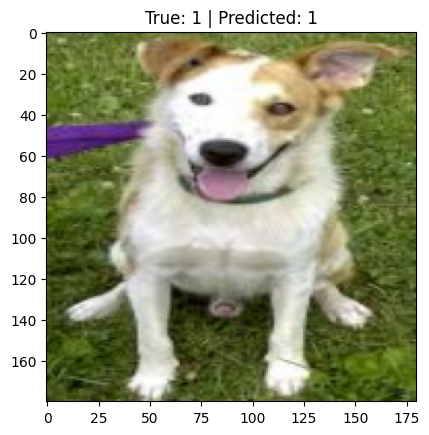

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


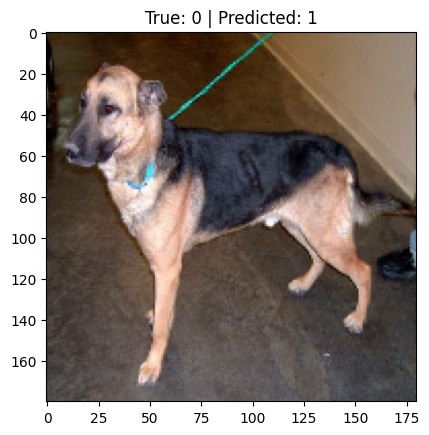

1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


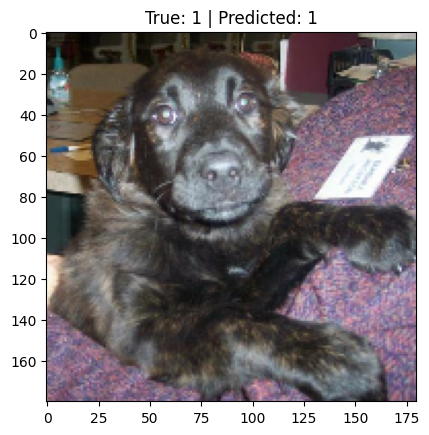

In [19]:
def evaluate_vgg16(model, dataset, conv_base, dataset_name):
    features = []
    labels = []
    for images, lbls in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        feature_batch = conv_base.predict(preprocessed_images)
        features.append(feature_batch)
        labels.extend(lbls.numpy())
    features = np.concatenate(features)
    labels = np.array(labels)

    predictions = model.predict(features)
    y_pred = (predictions > 0.5).astype(int).flatten()
    y_true = labels

    accuracy = np.mean(y_true == y_pred)
    print(f"{dataset_name} Accuracy: {accuracy:.2f}")

    cm = confusion_matrix(y_true, y_pred)
    print(f"Confusion Matrix ({dataset_name}):\n", cm)

    report = classification_report(y_true, y_pred, target_names=["Cat", "Dog"])
    print(f"Classification Report ({dataset_name}):\n", report)

    precision, recall, _ = precision_recall_curve(y_true, predictions.flatten())
    plt.figure()
    plt.plot(recall, precision, label=f"PR Curve ({dataset_name})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve ({dataset_name})")
    plt.legend()
    plt.show()

    wrong_predictions = np.where(y_true != y_pred)[0]
    return y_true, y_pred, wrong_predictions

print("Evaluating VGG16...")
y_true_vgg, y_pred_vgg, wrong_vgg = evaluate_vgg16(model, test_dataset, conv_base, "VGG16")

def analyze_failures_vgg16(dataset, conv_base, y_true, y_pred, wrong_indices):
    print(f"Analyzing Failures for VGG16...")
    for idx in wrong_indices[:5]:
        for batch_idx, (images, labels) in enumerate(dataset):
            if idx < len(labels):
                preprocessed_images = keras.applications.vgg16.preprocess_input(images)
                feature_batch = conv_base.predict(preprocessed_images)
                plt.figure()
                plt.imshow(images[idx].numpy().astype("uint8"))
                plt.title(f"True: {y_true[idx]} | Predicted: {y_pred[idx]}")
                plt.show()
                break
            idx -= len(labels)

analyze_failures_vgg16(test_dataset, conv_base, y_true_vgg, y_pred_vgg, wrong_vgg)


# 5. Conclusions

# SqeezeNet
The SqueezeNet model trained on the dataset  of classify dogs and cats images achieved an overall accuracy of 50%. It is equivalent to random guessing. The precision-recall curve seem don't have any change. The curve also illustrates the model's inability to distinguish between the two classes. This could due to the model's poor performance stems from data issues, SqueezeNet's limitations, and training inefficiencies.

While chacking the Confusion Matrix, the model classified all "Cat" images correctly but failed entirely to classify "Dog" images. This might show that  a significant class imbalance in the predictions, though not necessarily in the dataset. The other result testinga all show the same thing.

# Vgg16
The VGG16 model achieved outstanding performance. There is an overall accuracy of 98%. The confusion matrix and classification report indicate balanced performance across both classes. Also while checking with precision, recall, and F1-scores close to 0.98 for both cats and dogs. The PR curve further demonstrates the model's excellent ability to distinguish between the two classes.

Vgg16 has a stronger ability on classify the images on this dataset. The conclusion can also be the model's complexity is well-suited to capture the nuanced differences between the two classes.